# Task 1.2: Data Preparation + PCA & Clastering

Improve the quality of your data and prepare it by extracting new features interesting for describing the incidents. Some examples of indicators to be computed are:

- How many males are involved in incidents relative to the total number of males for the same city and in the same period?
- How many injured and killed people have been involved relative to the total injured and killed people in the same congressional district in a given period of time?
- Ratio of the number of killed people in the incidents relative to the number of participants in the incident
- Ratio of unharmed people in the incidents relative to the average of unharmed people in the same period

Note that these examples are not mandatory, and teams can define their own indicators. Each indicator must be correlated with a description and, when necessary, its mathematical formulation. The extracted variables will be useful for the clustering analysis in the second project's task. Once the set of indicators is computed, the team should explore the new features for a statistical analysis, including distributions, outliers, visualizations, and correlations.

For task 1.1 see the corresponding Notebook in [Task 1.1 - Data Understanding](Task1_Data_Understanding.ipynb).

For this task we followed the following check structure: [#WIP]()
1. Data aggregation
2. Reduction of dimensionality
3. Data cleaning
4. Discretization
5. Data transformation
6. Principal Component Analysis via Covariance Matrix
8. Data Similarity via Entropy and proximity coefficients


In [1]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)

# Load dataset from data understanding
#df_incident_du = pd.read_csv('../ds/cleaned/incidents_cleaned.csv')
df = pd.read_hdf('../ds/cleaned/incidents_cleaned.h5', key = 'df')
df_incident_du = df.copy()   
df_poverty_du = pd.read_csv('../ds/cleaned/poverty_cleaned.csv')
df_years_state_du = pd.read_csv('../ds/cleaned/year_state_votes_cleaned.csv')


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Check if dataset loaded correctly
#df_incident_du.head()
#df_poverty_du.head()
df_years_state_du.head(-1)
#df_incident_du.info()
# how many different years
df_years_state_du['year'].unique()


array([2014, 2016, 2018, 2020, 2022, 2015, 2017, 2019, 2021])

### Fix little problem with reimporting datasets

CSV files do not store informations about categories and datatypes like the one we saved.

# Joining the datasets

We have three dataset: the one with the incidents, one with poverty by state (just two columns) and one with year, state and how much votes each party got. We want to join the three datasets in order to have a single dataset with all the information we need. 

In [3]:
# We need to do merge function from pandas

df_merged_incident_poverty = pd.merge(df_incident_du ,df_poverty_du, on=['year', 'state'], how='left')

# This produces nans on 70k party columns...
#df_merged_incident_votes = pd.merge(df_merged_incident_poverty ,df_years_state_du, on=['year', 'state', 'congressional_district'], how='left')

df_merged_incident_poverty.head()

#df_merged_incident_votes.head()

df_merged = df_merged_incident_poverty.copy()

# drop from memory using
del [[df_merged_incident_poverty]]

# now merge the two merged
#df_merged = pd.merge(df_merged_incident_votes ,df_poverty_du, on=['year', 'state'], how='left')

df_merged.head()

date       state  city_or_county  latitude  longitude  \
0 2014-01-01    Arkansas      Pine Bluff   34.2291   -91.9779   
1 2014-01-01  California     Bakersfield   35.3229  -119.0380   
2 2014-01-01        Iowa       Iowa City   41.6611   -91.5302   
3 2014-01-01    New York        Brooklyn   40.6505   -73.9573   
4 2014-01-01    Colorado  Grand Junction   39.0496  -108.5250   

   congressional_district  participant_age1 participant_age_group1  \
0                       4                26              Adult 18+   
1                      23                28              Adult 18+   
2                       2                35              Adult 18+   
3                       9                28              Adult 18+   
4                       3                47              Adult 18+   

  participant_gender1  avg_age_participants  n_participants_child  \
0                Male                    26                     0   
1                Male                    28                     0   
2              Female                    35                     0   
3                Male                    29                     0   
4                Male                    47                     0   

   n_participants_teen  n_females  n_killed  n_injured  n_arrested  \
0                    0          0         0          1           0   
1                    0          0         0          2           0   
2                    0          2         0          1           0   
3                    0          1         0          3           0   
4                    0          0         1          0           0   

   n_unharmed  n_participants                  incident_characteristics1  \
0           1               2                     Shot - Wounded/Injured   
1           0               2                     Shot - Wounded/Injured   
2           1               2                                      other   
3           0               3                     Shot - Wounded/Injured   
4           0               1  Shot - Dead (murder, accidental, suicide)   

   year  povertyPercentage  
0  2014               16.8  
1  2014               14.5  
2  2014               10.1  
3  2014               13.4  
4  2014               10.2

In [4]:
# join df_years_state_du and df_incident ()

In [5]:

df_merged = pd.merge(df_merged ,df_years_state_du, on=['year', 'state', 'congressional_district'], how='left')  

In [6]:
df_merged.head(-1)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134579 entries, 0 to 134578
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       134579 non-null  datetime64[ns]
 1   state                      134579 non-null  object        
 2   city_or_county             134579 non-null  object        
 3   latitude                   134579 non-null  float64       
 4   longitude                  134579 non-null  float64       
 5   congressional_district     134579 non-null  int64         
 6   participant_age1           134579 non-null  int64         
 7   participant_age_group1     134579 non-null  category      
 8   participant_gender1        134579 non-null  category      
 9   avg_age_participants       134579 non-null  int64         
 10  n_participants_child       134579 non-null  int64         
 11  n_participants_teen        134579 non-null  int64   

# Implementation of default indexes
### 1. *How many males are involved in incidents w.r.t. the total number of males for the same city and in the same period?*

In [7]:
# TODO


male_incidents = df_merged.copy()

male_incidents['n_males'] = male_incidents['n_participants'] - male_incidents['n_females']

# groupy by city and perid
male_incidents = male_incidents.groupby(['city_or_county', 'year'])['n_males'].sum()

males_not_sum = df_merged.copy()

males_not_sum['n_males'] = males_not_sum['n_participants'] - males_not_sum['n_females']


# merge
merged_males = pd.merge(male_incidents, males_not_sum, on=['city_or_county', 'year'], how='left', suffixes=('_sum', '_not_sum'))


# Now divide the two columnd to get males_indicator : n_males_sum / males_not_sum
merged_males['male_indicator'] = merged_males['n_males_sum'] / merged_males['n_males_not_sum']

In [8]:
df_merged.head()


date       state  city_or_county  latitude  longitude  \
0 2014-01-01    Arkansas      Pine Bluff   34.2291   -91.9779   
1 2014-01-01  California     Bakersfield   35.3229  -119.0380   
2 2014-01-01        Iowa       Iowa City   41.6611   -91.5302   
3 2014-01-01    New York        Brooklyn   40.6505   -73.9573   
4 2014-01-01    Colorado  Grand Junction   39.0496  -108.5250   

   congressional_district  participant_age1 participant_age_group1  \
0                       4                26              Adult 18+   
1                      23                28              Adult 18+   
2                       2                35              Adult 18+   
3                       9                28              Adult 18+   
4                       3                47              Adult 18+   

  participant_gender1  avg_age_participants  n_participants_child  \
0                Male                    26                     0   
1                Male                    28                     0   
2              Female                    35                     0   
3                Male                    29                     0   
4                Male                    47                     0   

   n_participants_teen  n_females  n_killed  n_injured  n_arrested  \
0                    0          0         0          1           0   
1                    0          0         0          2           0   
2                    0          2         0          1           0   
3                    0          1         0          3           0   
4                    0          0         1          0           0   

   n_unharmed  n_participants                  incident_characteristics1  \
0           1               2                     Shot - Wounded/Injured   
1           0               2                     Shot - Wounded/Injured   
2           1               2                                      other   
3           0               3                     Shot - Wounded/Injured   
4           0               1  Shot - Dead (murder, accidental, suicide)   

   year  povertyPercentage       party  candidatevotes  totalvotes  
0  2014               16.8  REPUBLICAN        110789.0    206131.0  
1  2014               14.5  REPUBLICAN        100317.0    134043.0  
2  2014               10.1    DEMOCRAT        143431.0    273329.0  
3  2014               13.4    DEMOCRAT         70997.0    101606.0  
4  2014               10.2  REPUBLICAN        163011.0    281141.0

In most of the incidents the ratio is equal to 1 but some incidents report an increased partecipation of mlaes respect to the total males in the smame period for the same city. Let's analyze in which state and in which city or county those incidents happens:

It's noticeable to highlight that the city of Springfield is not in the State of Florida, so can have a relevance for the record that refer the Springfield city.


## 2. Ratio of the number of the killed people in the incident w.r.t. the number of participants in the incident

How we can see the majority of the incidents have a ratio of 0 and there are not a lot of different ration, they are just 7,
we could try to discretize this feature in order to have a better visualization. By making this a categorical feature we can see that the majority of the incidents have a ratio of 0 and there are not a lot of different ration, they are just 7.

Let's visualize it with a barplot.

In [9]:

# divide for each incident n_killed by n_participants
df_merged['ratio_killed'] = df_merged['n_killed'] / df_merged['n_participants']


In [10]:

# groupby different value of n_killed_per_participant
print(df_merged.groupby('ratio_killed').size())

ratio_killed
0.000000    92428
0.250000     1830
0.333333     4667
0.500000    15855
0.666667      861
0.750000      136
1.000000    18802
dtype: int64


### Discretization of the ratio

Let's discretize these values into 3 main categories since we have a lot of incidents with ratio being 0 and this is first category: let's call it: **"No deaths"**, these can be those were someone just shot in the air or something like this, we could do more by using the **incidents_charactetistics1** and see what type of those is the majority.

Then we have some of incidents with ratio from 0.25, 0.33, 0.5 (that is the majority), 0.66 and 0.75 and this is second category, so incidents where someone died but not all the people involved in the incident: let's call it: **"Some deaths"**.

Then we have another category with lots of incidents with ratio being 1 and this is third category: **"All deaths"**.

<AxesSubplot:ylabel='ratio_killed'>

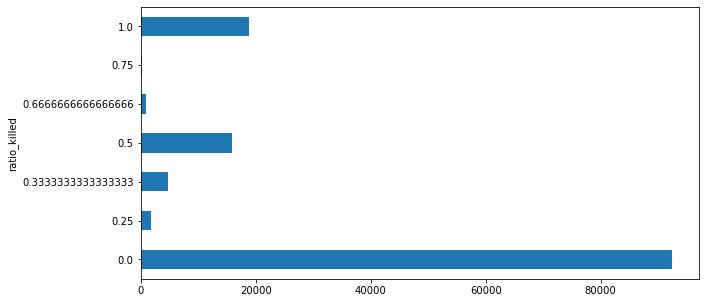

In [11]:
# Barplot of n_killed_per_participant and number of incidents using our groupby rotated along the y axis
df_merged.groupby('ratio_killed').size().plot(kind='barh', figsize=(10, 5), rot=0)

#df_merged.groupby('n_killed_per_participant').size().plot(kind='bar', figsize=(10, 5), rot=0)

In [12]:
# Discretize by gathering the n_killed_per_participants into 3 categories as we discussed
# If ration is [0,0.1), then label is 'No deaths', if ratio is [0.1, 0.75), then label is 'Some deaths', if ratio is [0.75, 1], then label is 'All deaths'

ratios = {'No deaths': [0, 0.1], 'Some deaths': [0.1, 0.75], 'All deaths': [0.75, 1]}

# map to n_killed_per_participant

df_merged['death_level'] = df_merged['ratio_killed'].map(
    lambda x: 'No deaths' if x >= ratios['No deaths'][0] and x < ratios['No deaths'][1] else 
    ('Some deaths' if x >= ratios['Some deaths'][0] and x < ratios['Some deaths'][1] else 'All deaths'))


<AxesSubplot:ylabel='death_level'>

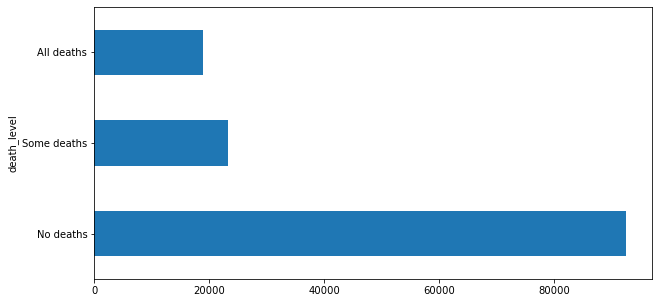

In [13]:
#df_merged.head()
# order the categories from 'No deaths' to 'All deaths'
df_merged['death_level'] = pd.Categorical(df_merged['death_level'], 
                                                       categories=['No deaths', 'Some deaths', 'All deaths'], 
                                                       ordered=True)

# Barplot after discretization
df_merged.groupby('death_level').size().plot(kind='barh', figsize=(10, 5), rot=0)

## 3. How many injured and killed people have been involved w.r.t the total injured and killed people in the same STATE during 2016 - 2018

In [14]:
df_merged_incident_poverty = df_merged.copy()

desired_years = [2016, 2017, 2018]



df_filtered = df_merged_incident_poverty[df_merged_incident_poverty['year'].isin(desired_years)]
# Group by congressional district
grouped_district = df_filtered.groupby('state')


#number of injured for each district
total_injured_district = df_merged_incident_poverty.groupby('state')['n_injured'].sum().reset_index()

#number of killed for each district
total_killed_district = df_merged_incident_poverty.groupby('state')['n_killed'].sum().reset_index()

# Calculate the total number of killed and injured people for each district
total_killed_injured = grouped_district[['n_killed', 'n_injured']].sum().reset_index()

# Calculate the total number of injured people relative to the total of injured and killed for each district
total_killed_injured['percentage_injured'] = (total_killed_injured['n_injured'] / (total_killed_injured['n_killed'] + total_killed_injured['n_injured'])) * 100

# Remove this since they are inversely correlated (-1)

# Calculate the total number of injured people relative to the total of injured and killed for each district
total_killed_injured['percentage_killed'] = (total_killed_injured['n_killed'] / (total_killed_injured['n_killed'] + total_killed_injured['n_injured'])) * 100

# Drop the n_killed and n_injured columns as are useless and duplicated
total_killed_injured.drop(['n_killed', 'n_injured'], axis=1, inplace=True)

# Merge the total_killed_injured DataFrame with the total_killed_district DataFrame



df_merged = pd.merge(df_merged, total_killed_injured, on=['state'], how='left')




In [15]:
df_merged.head()


date       state  city_or_county  latitude  longitude  \
0 2014-01-01    Arkansas      Pine Bluff   34.2291   -91.9779   
1 2014-01-01  California     Bakersfield   35.3229  -119.0380   
2 2014-01-01        Iowa       Iowa City   41.6611   -91.5302   
3 2014-01-01    New York        Brooklyn   40.6505   -73.9573   
4 2014-01-01    Colorado  Grand Junction   39.0496  -108.5250   

   congressional_district  participant_age1 participant_age_group1  \
0                       4                26              Adult 18+   
1                      23                28              Adult 18+   
2                       2                35              Adult 18+   
3                       9                28              Adult 18+   
4                       3                47              Adult 18+   

  participant_gender1  avg_age_participants  n_participants_child  \
0                Male                    26                     0   
1                Male                    28                     0   
2              Female                    35                     0   
3                Male                    29                     0   
4                Male                    47                     0   

   n_participants_teen  n_females  n_killed  n_injured  n_arrested  \
0                    0          0         0          1           0   
1                    0          0         0          2           0   
2                    0          2         0          1           0   
3                    0          1         0          3           0   
4                    0          0         1          0           0   

   n_unharmed  n_participants                  incident_characteristics1  \
0           1               2                     Shot - Wounded/Injured   
1           0               2                     Shot - Wounded/Injured   
2           1               2                                      other   
3           0               3                     Shot - Wounded/Injured   
4           0               1  Shot - Dead (murder, accidental, suicide)   

   year  povertyPercentage       party  candidatevotes  totalvotes  \
0  2014               16.8  REPUBLICAN        110789.0    206131.0   
1  2014               14.5  REPUBLICAN        100317.0    134043.0   
2  2014               10.1    DEMOCRAT        143431.0    273329.0   
3  2014               13.4    DEMOCRAT         70997.0    101606.0   
4  2014               10.2  REPUBLICAN        163011.0    281141.0   

   ratio_killed death_level  percentage_injured  percentage_killed  
0           0.0   No deaths           58.789954          41.210046  
1           0.0   No deaths           45.310907          54.689093  
2           0.0   No deaths           71.662763          28.337237  
3           0.0   No deaths           70.237122          29.762878  
4           1.0  All deaths           43.229167          56.770833

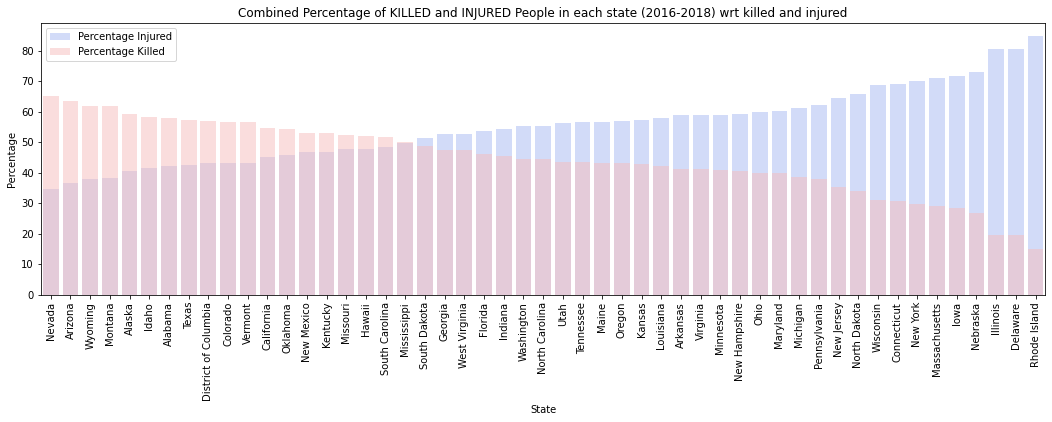

In [16]:
# Plot for combined percentage of killed and injured people
plt.figure(figsize=(18, 5))

# Order by percentage of killed people
total_killed_injured = total_killed_injured.sort_values(by='percentage_killed', ascending=False)

# Plotting killed percentage
# Plotting injured percentage
sns.barplot(x='state', y='percentage_injured', data=total_killed_injured, color='#99b3ff', label='Percentage Injured', alpha = 0.5)
sns.barplot(x='state', y='percentage_killed', data=total_killed_injured, color='#ffb3b3', label='Percentage Killed' , alpha = 0.5)
plt.title('Combined Percentage of KILLED and INJURED People in each state (2016-2018) wrt killed and injured')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.legend()

plt.show()

del [[total_killed_injured]]


## 4. *Ratio of unharmed people in the incident w.r.t. the average of unharmed people involved in incidents for the same period*

Due to dataframe dimension we computed the fourth index in another Notebook to avoid kernel panic. 

We save the result and retrieve the aggregated dataset from the file `index_4_cleaned.csv` to join the new indicator with the already computed in DF `df_merged`.

In [17]:
df_merged_unharmed = pd.read_csv('../ds/cleaned/index_4_cleaned.csv')

# groupby year
df_merged_unharmed = df_merged_unharmed.groupby('year')['unharmed_ratio'].mean().reset_index()


Another visualization is by using the bar chart:

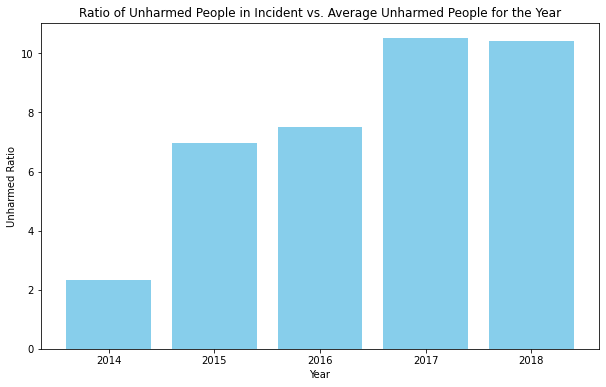

In [18]:
plt.figure(figsize=(10, 6))
plt.bar(df_merged_unharmed['year'], df_merged_unharmed['unharmed_ratio'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Unharmed Ratio')
plt.title('Ratio of Unharmed People in Incident vs. Average Unharmed People for the Year')
plt.show()


df_merged = pd.merge(df_merged, df_merged_unharmed, on=['year'], how='left')


# Our indicators

## 5. *Number of incident density per state*

Let visualize with the map and the density of incidents per state.

In [19]:
import plotly.graph_objs as go

# density of incident per state

# Densities are n_participants in that state divided by the total number of participants in the dataset
densities = df_merged.groupby('state')['n_participants'].sum()/ df_merged['n_participants'].sum()

# normalize densities using min-max normalization
densities = (densities - densities.min()) / (densities.max() - densities.min())

# order by density
densities = densities.sort_values()

# plot a bar plot

data = [go.Bar(
            x=densities.index, # assign x as the dataframe column 'x'
            y=densities.values
    )]  

py.iplot(data, filename='basic-bar')

# add this as index to the dataframe
df_merged['density_incident_state'] = df_merged['state'].map(densities)


In [20]:
df_merged.head()

date       state  city_or_county  latitude  longitude  \
0 2014-01-01    Arkansas      Pine Bluff   34.2291   -91.9779   
1 2014-01-01  California     Bakersfield   35.3229  -119.0380   
2 2014-01-01        Iowa       Iowa City   41.6611   -91.5302   
3 2014-01-01    New York        Brooklyn   40.6505   -73.9573   
4 2014-01-01    Colorado  Grand Junction   39.0496  -108.5250   

   congressional_district  participant_age1 participant_age_group1  \
0                       4                26              Adult 18+   
1                      23                28              Adult 18+   
2                       2                35              Adult 18+   
3                       9                28              Adult 18+   
4                       3                47              Adult 18+   

  participant_gender1  avg_age_participants  n_participants_child  \
0                Male                    26                     0   
1                Male                    28                     0   
2              Female                    35                     0   
3                Male                    29                     0   
4                Male                    47                     0   

   n_participants_teen  n_females  n_killed  n_injured  n_arrested  \
0                    0          0         0          1           0   
1                    0          0         0          2           0   
2                    0          2         0          1           0   
3                    0          1         0          3           0   
4                    0          0         1          0           0   

   n_unharmed  n_participants                  incident_characteristics1  \
0           1               2                     Shot - Wounded/Injured   
1           0               2                     Shot - Wounded/Injured   
2           1               2                                      other   
3           0               3                     Shot - Wounded/Injured   
4           0               1  Shot - Dead (murder, accidental, suicide)   

   year  povertyPercentage       party  candidatevotes  totalvotes  \
0  2014               16.8  REPUBLICAN        110789.0    206131.0   
1  2014               14.5  REPUBLICAN        100317.0    134043.0   
2  2014               10.1    DEMOCRAT        143431.0    273329.0   
3  2014               13.4    DEMOCRAT         70997.0    101606.0   
4  2014               10.2  REPUBLICAN        163011.0    281141.0   

   ratio_killed death_level  percentage_injured  percentage_killed  \
0           0.0   No deaths           58.789954          41.210046   
1           0.0   No deaths           45.310907          54.689093   
2           0.0   No deaths           71.662763          28.337237   
3           0.0   No deaths           70.237122          29.762878   
4           1.0  All deaths           43.229167          56.770833   

   unharmed_ratio  density_incident_state  
0        2.345189                0.136149  
1        2.345189                0.639968  
2        2.345189                0.096973  
3        2.345189                0.534650  
4        2.345189                0.097775

## 6. *Ratio males to females per incident*

This can arise some information with the other categorical variables.


In [21]:
# ratio males to females participants in each incident
# in order to get this ratio

df_merged['males_to_females_ratio'] = (df_merged['n_participants']-df_merged['n_females']) / df_merged['n_females'].replace(0, 1)

# count in how many incidents females are 0 in %
# take a row check if females are 0 and add 1 then sum all and divide by total number of rows


#### Females appears only in 20% of the incidents

In [22]:
# Calculate the number of rows where n_females is 0
num_zero_females = (df_merged['n_females'] == 0).sum()

# Calculate the total number of rows
total_rows = len(df_merged)

# Calculate the percentage
percentage_zero_females = (num_zero_females / total_rows) * 100
print(percentage_zero_females)

81.22589705674734


In [23]:
df_merged.head()


# This was saved for exporting clustering in a new file
# save dataframe csv

#df_merged.to_csv('../ds/cleaned/merged.csv', index=False)

date       state  city_or_county  latitude  longitude  \
0 2014-01-01    Arkansas      Pine Bluff   34.2291   -91.9779   
1 2014-01-01  California     Bakersfield   35.3229  -119.0380   
2 2014-01-01        Iowa       Iowa City   41.6611   -91.5302   
3 2014-01-01    New York        Brooklyn   40.6505   -73.9573   
4 2014-01-01    Colorado  Grand Junction   39.0496  -108.5250   

   congressional_district  participant_age1 participant_age_group1  \
0                       4                26              Adult 18+   
1                      23                28              Adult 18+   
2                       2                35              Adult 18+   
3                       9                28              Adult 18+   
4                       3                47              Adult 18+   

  participant_gender1  avg_age_participants  n_participants_child  \
0                Male                    26                     0   
1                Male                    28                     0   
2              Female                    35                     0   
3                Male                    29                     0   
4                Male                    47                     0   

   n_participants_teen  n_females  n_killed  n_injured  n_arrested  \
0                    0          0         0          1           0   
1                    0          0         0          2           0   
2                    0          2         0          1           0   
3                    0          1         0          3           0   
4                    0          0         1          0           0   

   n_unharmed  n_participants                  incident_characteristics1  \
0           1               2                     Shot - Wounded/Injured   
1           0               2                     Shot - Wounded/Injured   
2           1               2                                      other   
3           0               3                     Shot - Wounded/Injured   
4           0               1  Shot - Dead (murder, accidental, suicide)   

   year  povertyPercentage       party  candidatevotes  totalvotes  \
0  2014               16.8  REPUBLICAN        110789.0    206131.0   
1  2014               14.5  REPUBLICAN        100317.0    134043.0   
2  2014               10.1    DEMOCRAT        143431.0    273329.0   
3  2014               13.4    DEMOCRAT         70997.0    101606.0   
4  2014               10.2  REPUBLICAN        163011.0    281141.0   

   ratio_killed death_level  percentage_injured  percentage_killed  \
0           0.0   No deaths           58.789954          41.210046   
1           0.0   No deaths           45.310907          54.689093   
2           0.0   No deaths           71.662763          28.337237   
3           0.0   No deaths           70.237122          29.762878   
4           1.0  All deaths           43.229167          56.770833   

   unharmed_ratio  density_incident_state  males_to_females_ratio  
0        2.345189                0.136149                     2.0  
1        2.345189                0.639968                     2.0  
2        2.345189                0.096973                     0.0  
3        2.345189                0.534650                     2.0  
4        2.345189                0.097775                     1.0

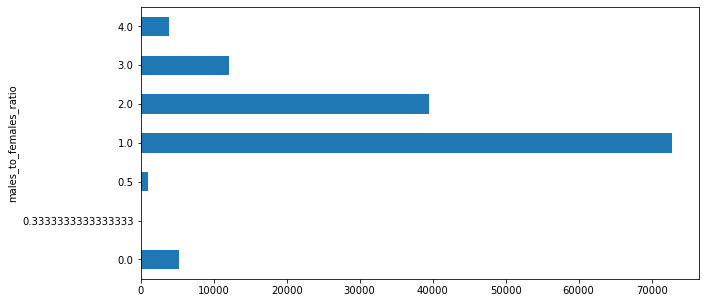

In [24]:
# Group by ratio male females and do barplot

df_merged.groupby('males_to_females_ratio')['participant_age_group1'].count().plot(kind='barh', figsize=(10, 5), rot=0) 

# We see very few incidents from 0 to 0.5, then a lot at 1, then half than the 1 for the ratio of 2, and so on until 4
# We can say that in half of incidents the ratio is 1 and in the rest more mens dies...

df_merged_pca = df_merged.copy()

In [25]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134579 entries, 0 to 134578
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       134579 non-null  datetime64[ns]
 1   state                      134579 non-null  object        
 2   city_or_county             134579 non-null  object        
 3   latitude                   134579 non-null  float64       
 4   longitude                  134579 non-null  float64       
 5   congressional_district     134579 non-null  int64         
 6   participant_age1           134579 non-null  int64         
 7   participant_age_group1     134579 non-null  category      
 8   participant_gender1        134579 non-null  category      
 9   avg_age_participants       134579 non-null  int64         
 10  n_participants_child       134579 non-null  int64         
 11  n_participants_teen        134579 non-null  int64   

# 7. Votes by poverty and state #todo

Let's see if there is a correlation between the votes and the poverty.


# Preparing for last phase Correlation Analysis and PCA

In [26]:
# Check for head
df_merged_pca.head()

# check for nan

# There are 639 male_indicator, drop them
df_merged_pca.dropna(inplace=True)
# check for nan
df_merged_pca.isnull().sum()


date                         0
state                        0
city_or_county               0
latitude                     0
longitude                    0
congressional_district       0
participant_age1             0
participant_age_group1       0
participant_gender1          0
avg_age_participants         0
n_participants_child         0
n_participants_teen          0
n_females                    0
n_killed                     0
n_injured                    0
n_arrested                   0
n_unharmed                   0
n_participants               0
incident_characteristics1    0
year                         0
povertyPercentage            0
party                        0
candidatevotes               0
totalvotes                   0
ratio_killed                 0
death_level                  0
percentage_injured           0
percentage_killed            0
unharmed_ratio               0
density_incident_state       0
males_to_females_ratio       0
dtype: int64

# Correlation matrix after adding the new features

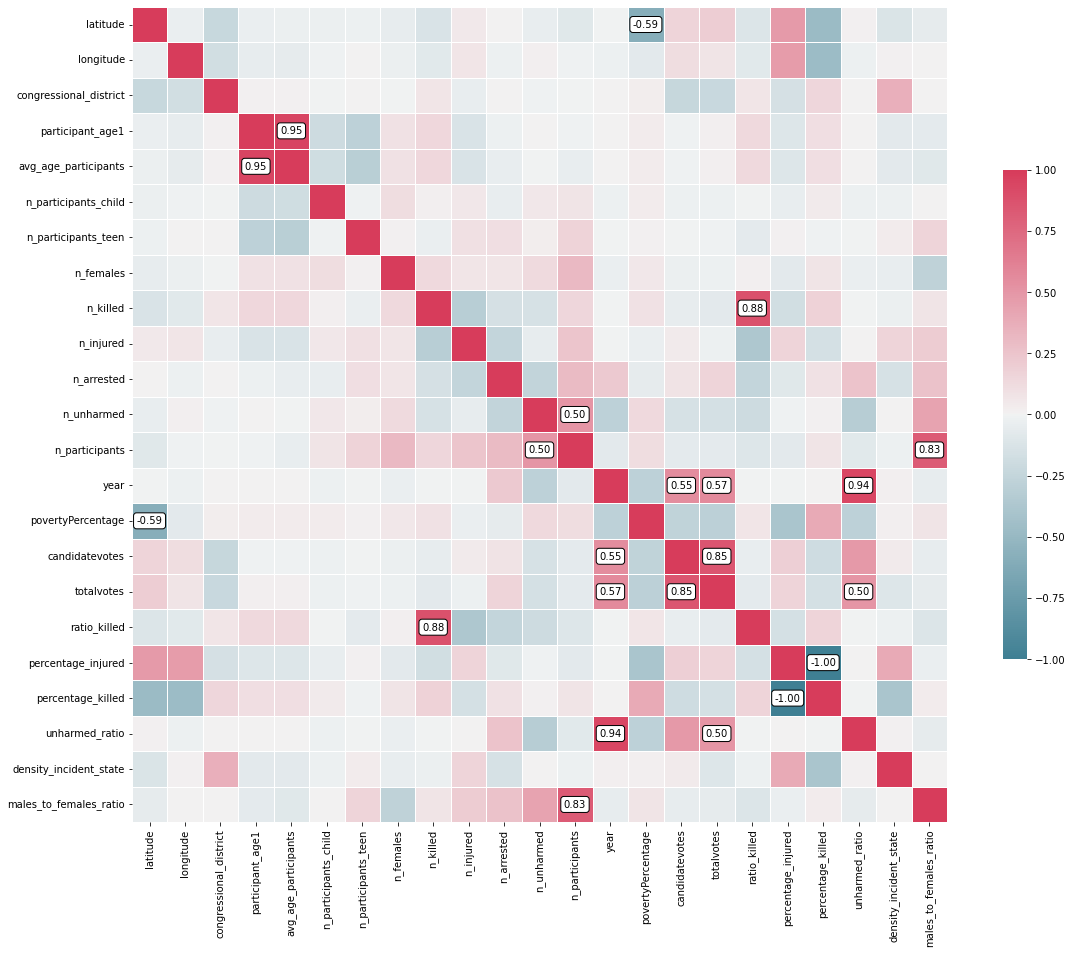

In [27]:

def plot_correlation(df_columns, df):
    
    # Compute the correlation matrix
    corr = df[df_columns].corr()

    # Generate a mask for the upper triangle
    #do not use np.bool is deprecated
    mask = np.zeros_like(corr, dtype=bool)
     
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 15))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 5, as_cmap=True)

    # Put numbers in squares that have correlation > 0.5 or < -0.5
    # Iterate over the correlation matrix and get the columns indices
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            if (corr.iloc[i, j] > 0.5 or corr.iloc[i, j] < -0.5) and i != j:
                # put text in square
                ax.text(j+0.5, i+0.5, '{:.2f}'.format(corr.iloc[i, j]), ha='center', va='center',
                        bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .6})



plot_correlation(df_merged_pca.select_dtypes(include=[np.number]).columns, df_merged_pca)

In [31]:
# Drop highly correlated columns again: Percentage killed (inversely proportional with injured)

df_merged_pca.drop(['percentage_killed'], axis=1, inplace=True)

# Why 0.94 with year-unharmed_ratio? We see unharmed ratio grow a lot from 2014 to 2018,
# a reason can be that with year growing there are more unharmed people in the incidents, so no drop this column

# participant_age_1 is highly correlated so we drop it because it's like a mean of the ages
df_merged_pca.drop(['participant_age1'], axis=1, inplace=True)




KeyError: "['percentage_killed'] not found in axis"

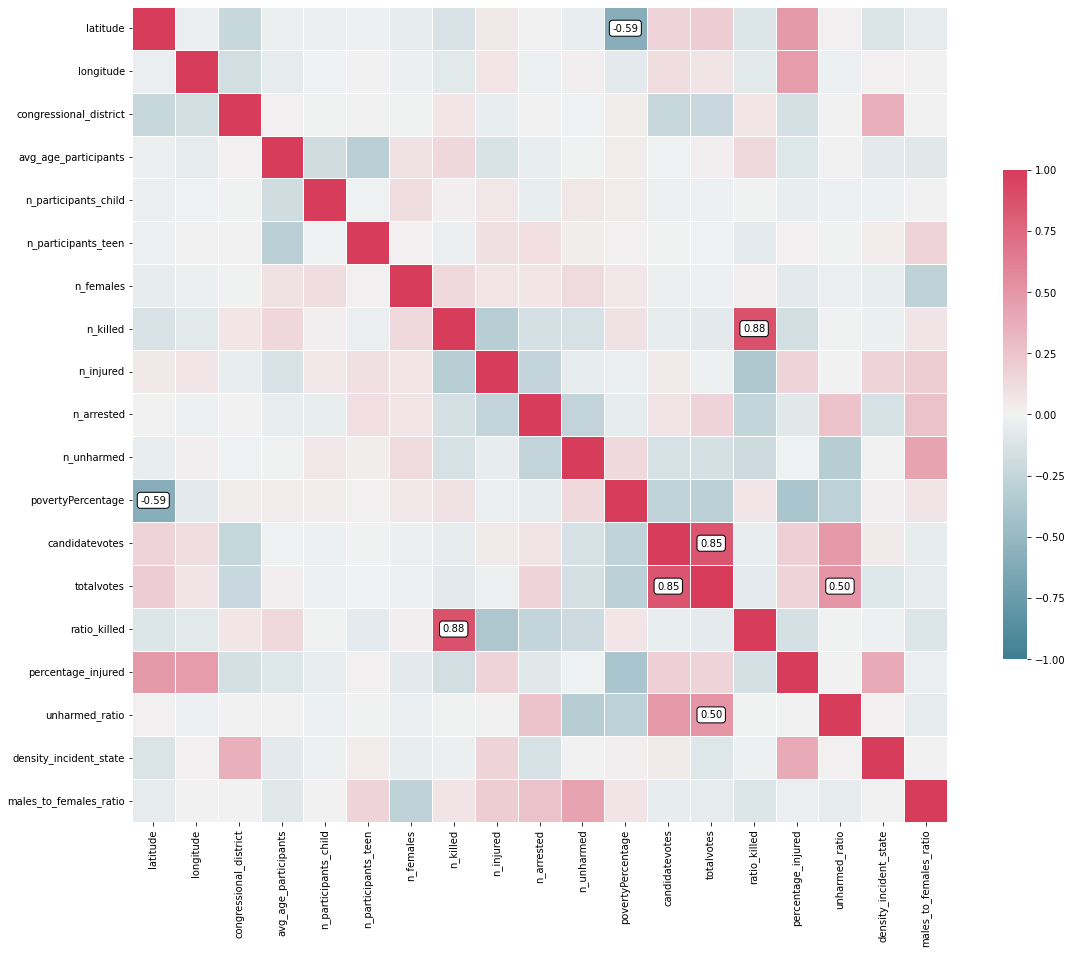

In [32]:
plot_correlation(df_merged_pca.select_dtypes(include=[np.number]).columns, df_merged_pca)


In [30]:
# removing more to get a very small space

# remove n_participants since we can get with males to females ratio about the same info and the fact that are all almosto male (80% of incidents involv only males)
df_merged_pca.drop(['n_participants'], axis=1, inplace=True)

# unharmed ratio and year are 0,94 correlated why? This means that when year grows unharmed ratio grows too, so we can drop year
df_merged_pca.drop(['year'], axis=1, inplace=True)


# now we will remove some columns that are not useful for clustering, 
# since we take only into account numerical columns when performing clustering some numerical
# columns are not useful for clustering: 

KeyError: "['max_age_participants'] not found in axis"

In [ ]:
# we should remove one between candidatevotes and totalvotes since they are highly correlated
# so we choose to remove candidatevotes since it's less correlated with the target variable

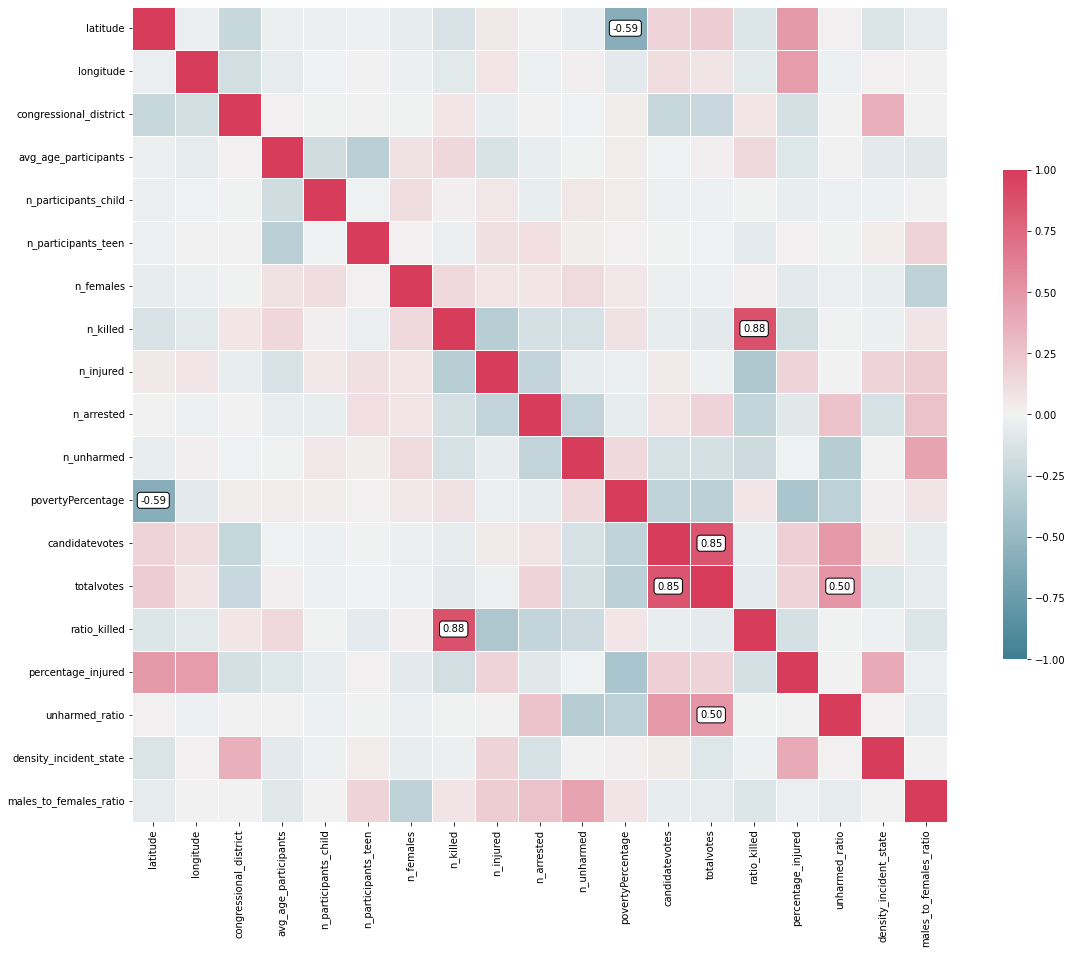

In [33]:
plot_correlation(df_merged_pca.select_dtypes(include=[np.number]).columns, df_merged_pca)

In [34]:
# save this now in HDF5
df_merged_pca.to_hdf('../ds/cleaned/reduced_for_clustering.h5', key = 'df', mode = 'w', format = 'table')

## PCA Analysis

Let's perform a PCA analysis on the new data we have created.


### Pairplot

These two pairplot contains information about variables that contains very few numbers in their distribution and usually are the number of unharmed, killed and so on...
We remove them in the final pairplot.

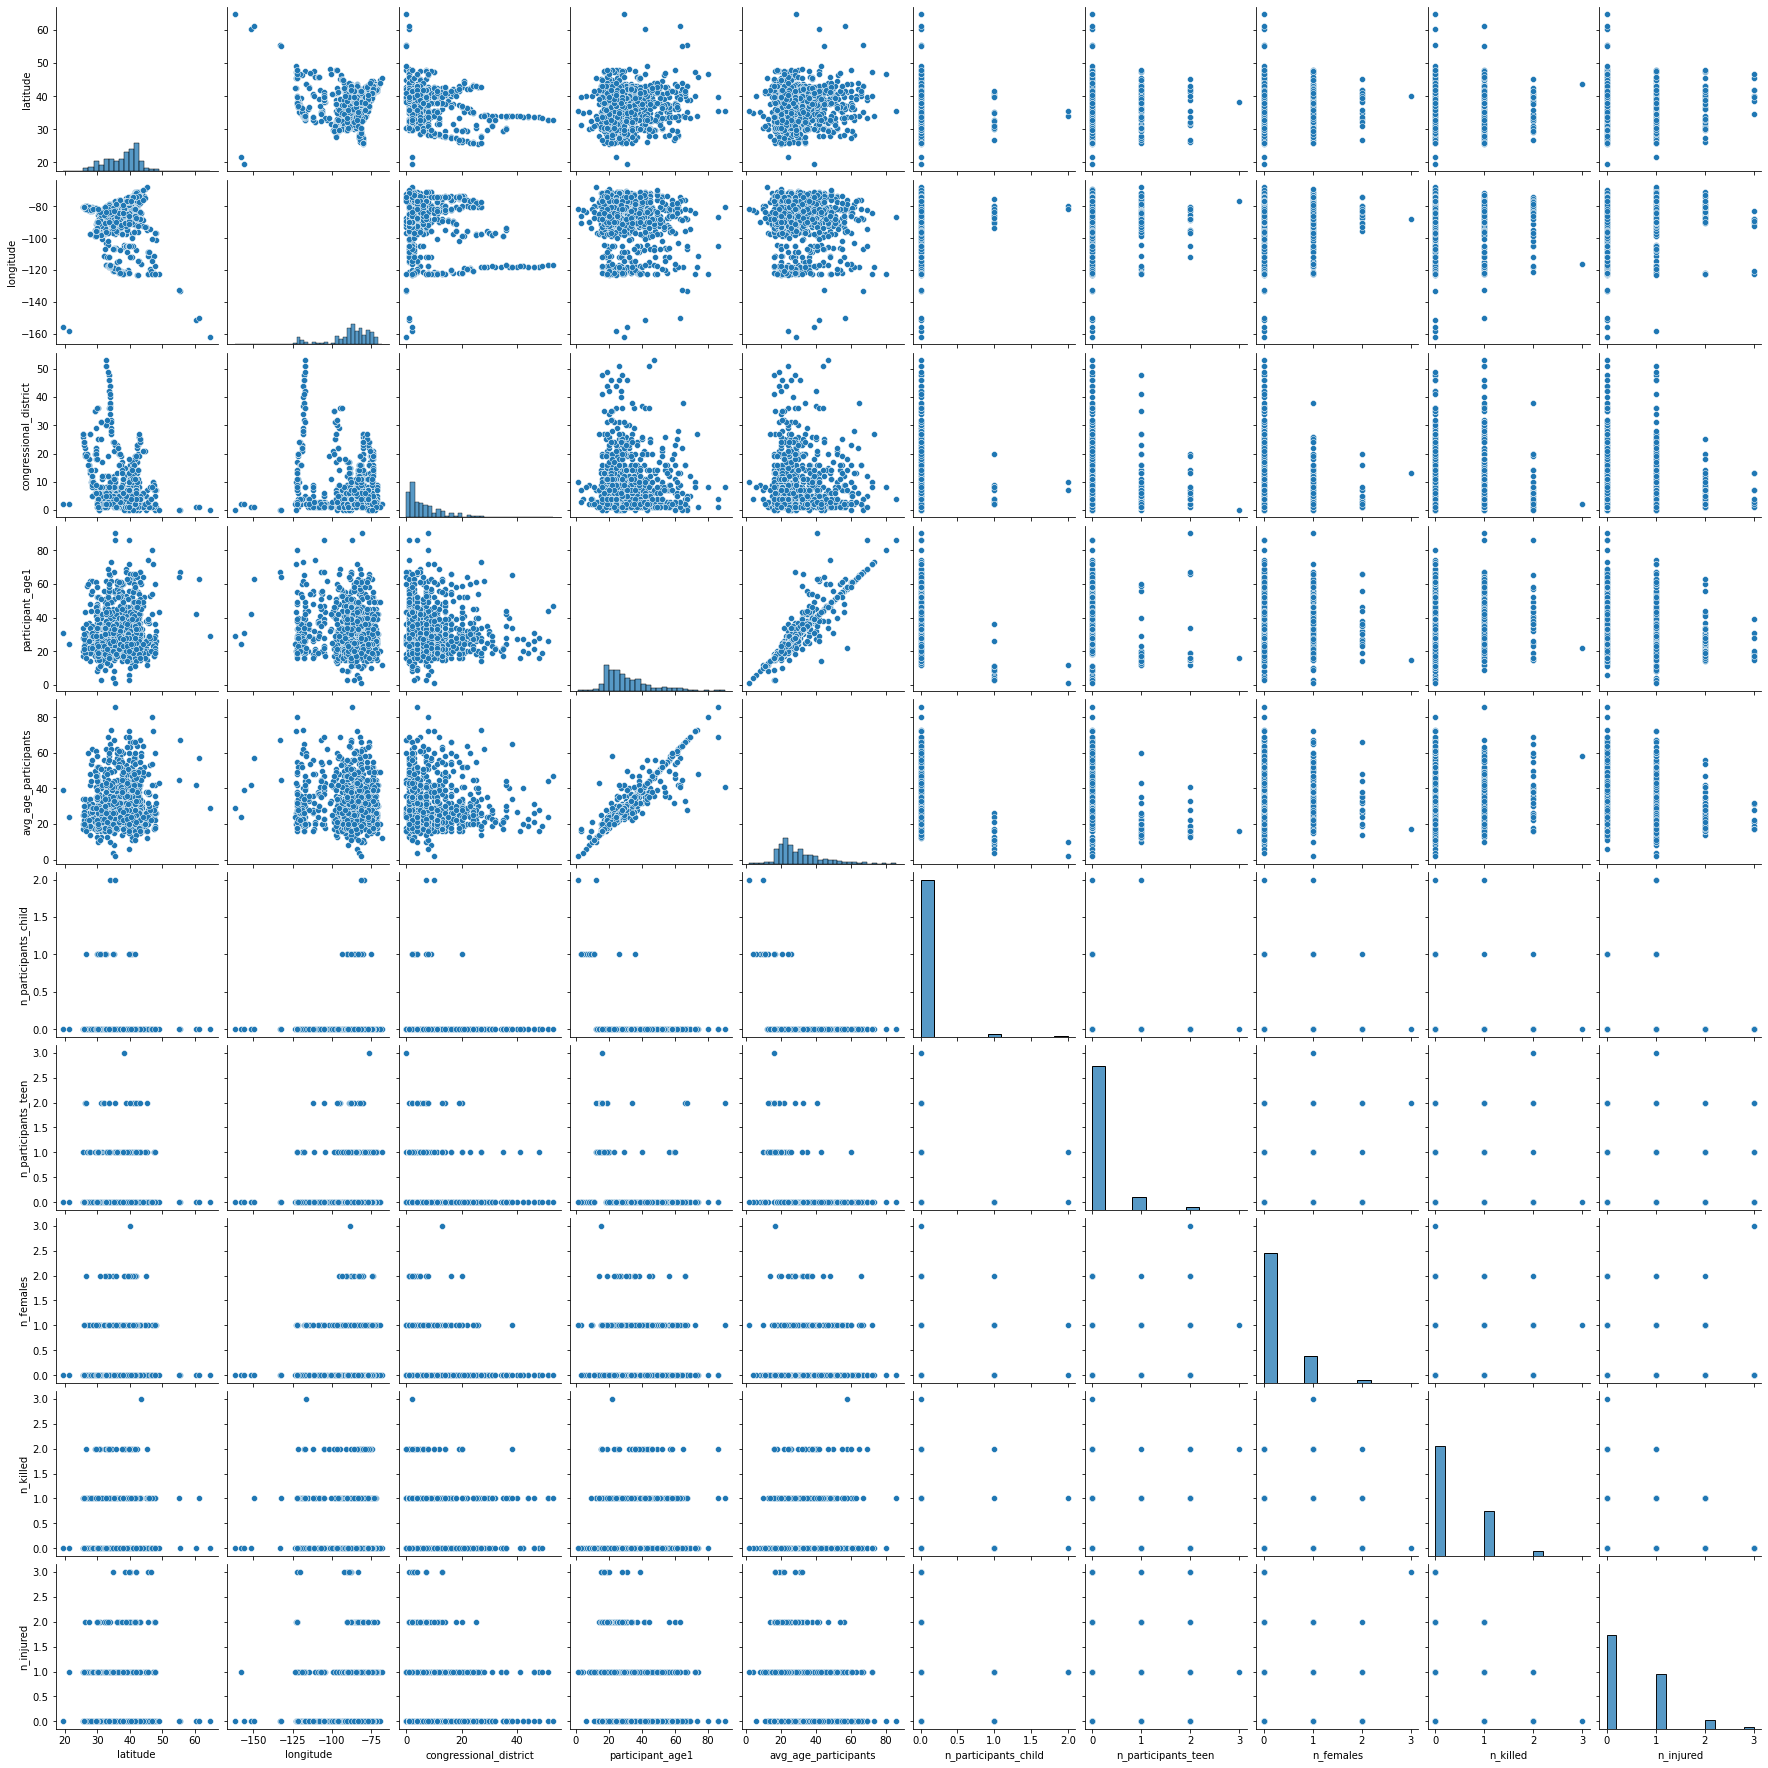

In [35]:
# pairplot only for numerical columns

# sample 1000 rows
df_merged_sample = df_merged.sample(1000)

# take first n numerical columns
numerical_columns = df_merged.select_dtypes(include=[np.number]).columns[:10]

# pairplot
sns.pairplot(df_merged_sample[numerical_columns])

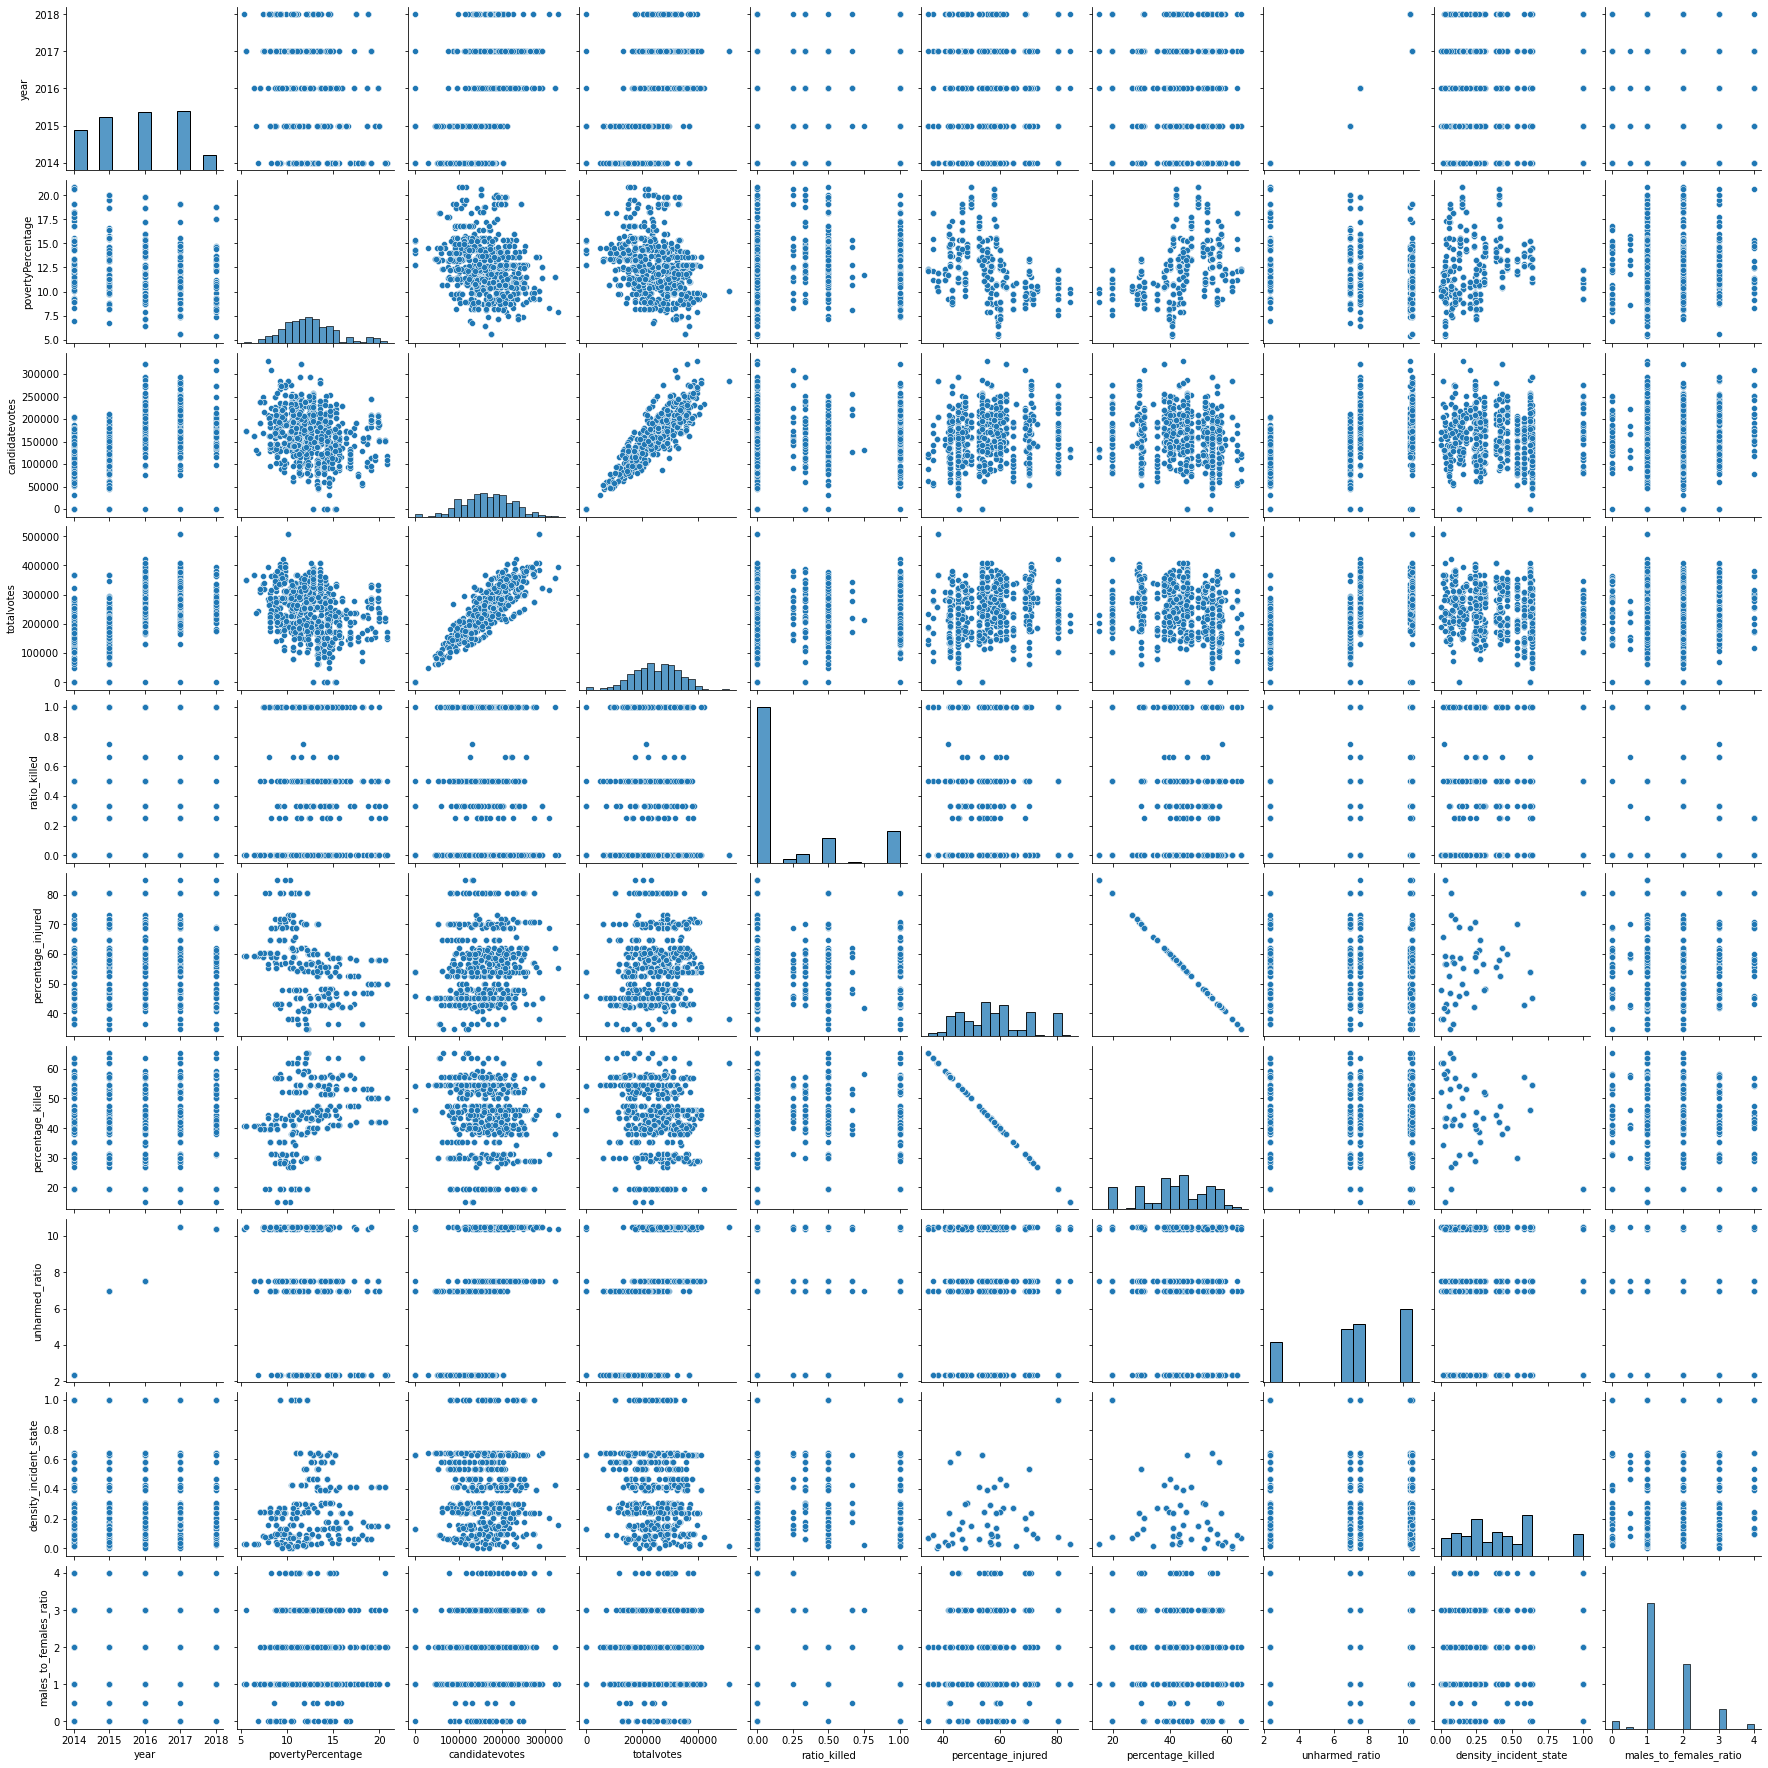

In [36]:
#take last n numerical columns
numerical_columns = df_merged.select_dtypes(include=[np.number]).columns[-10:]

# pairplot
sns.pairplot(df_merged_sample[numerical_columns])


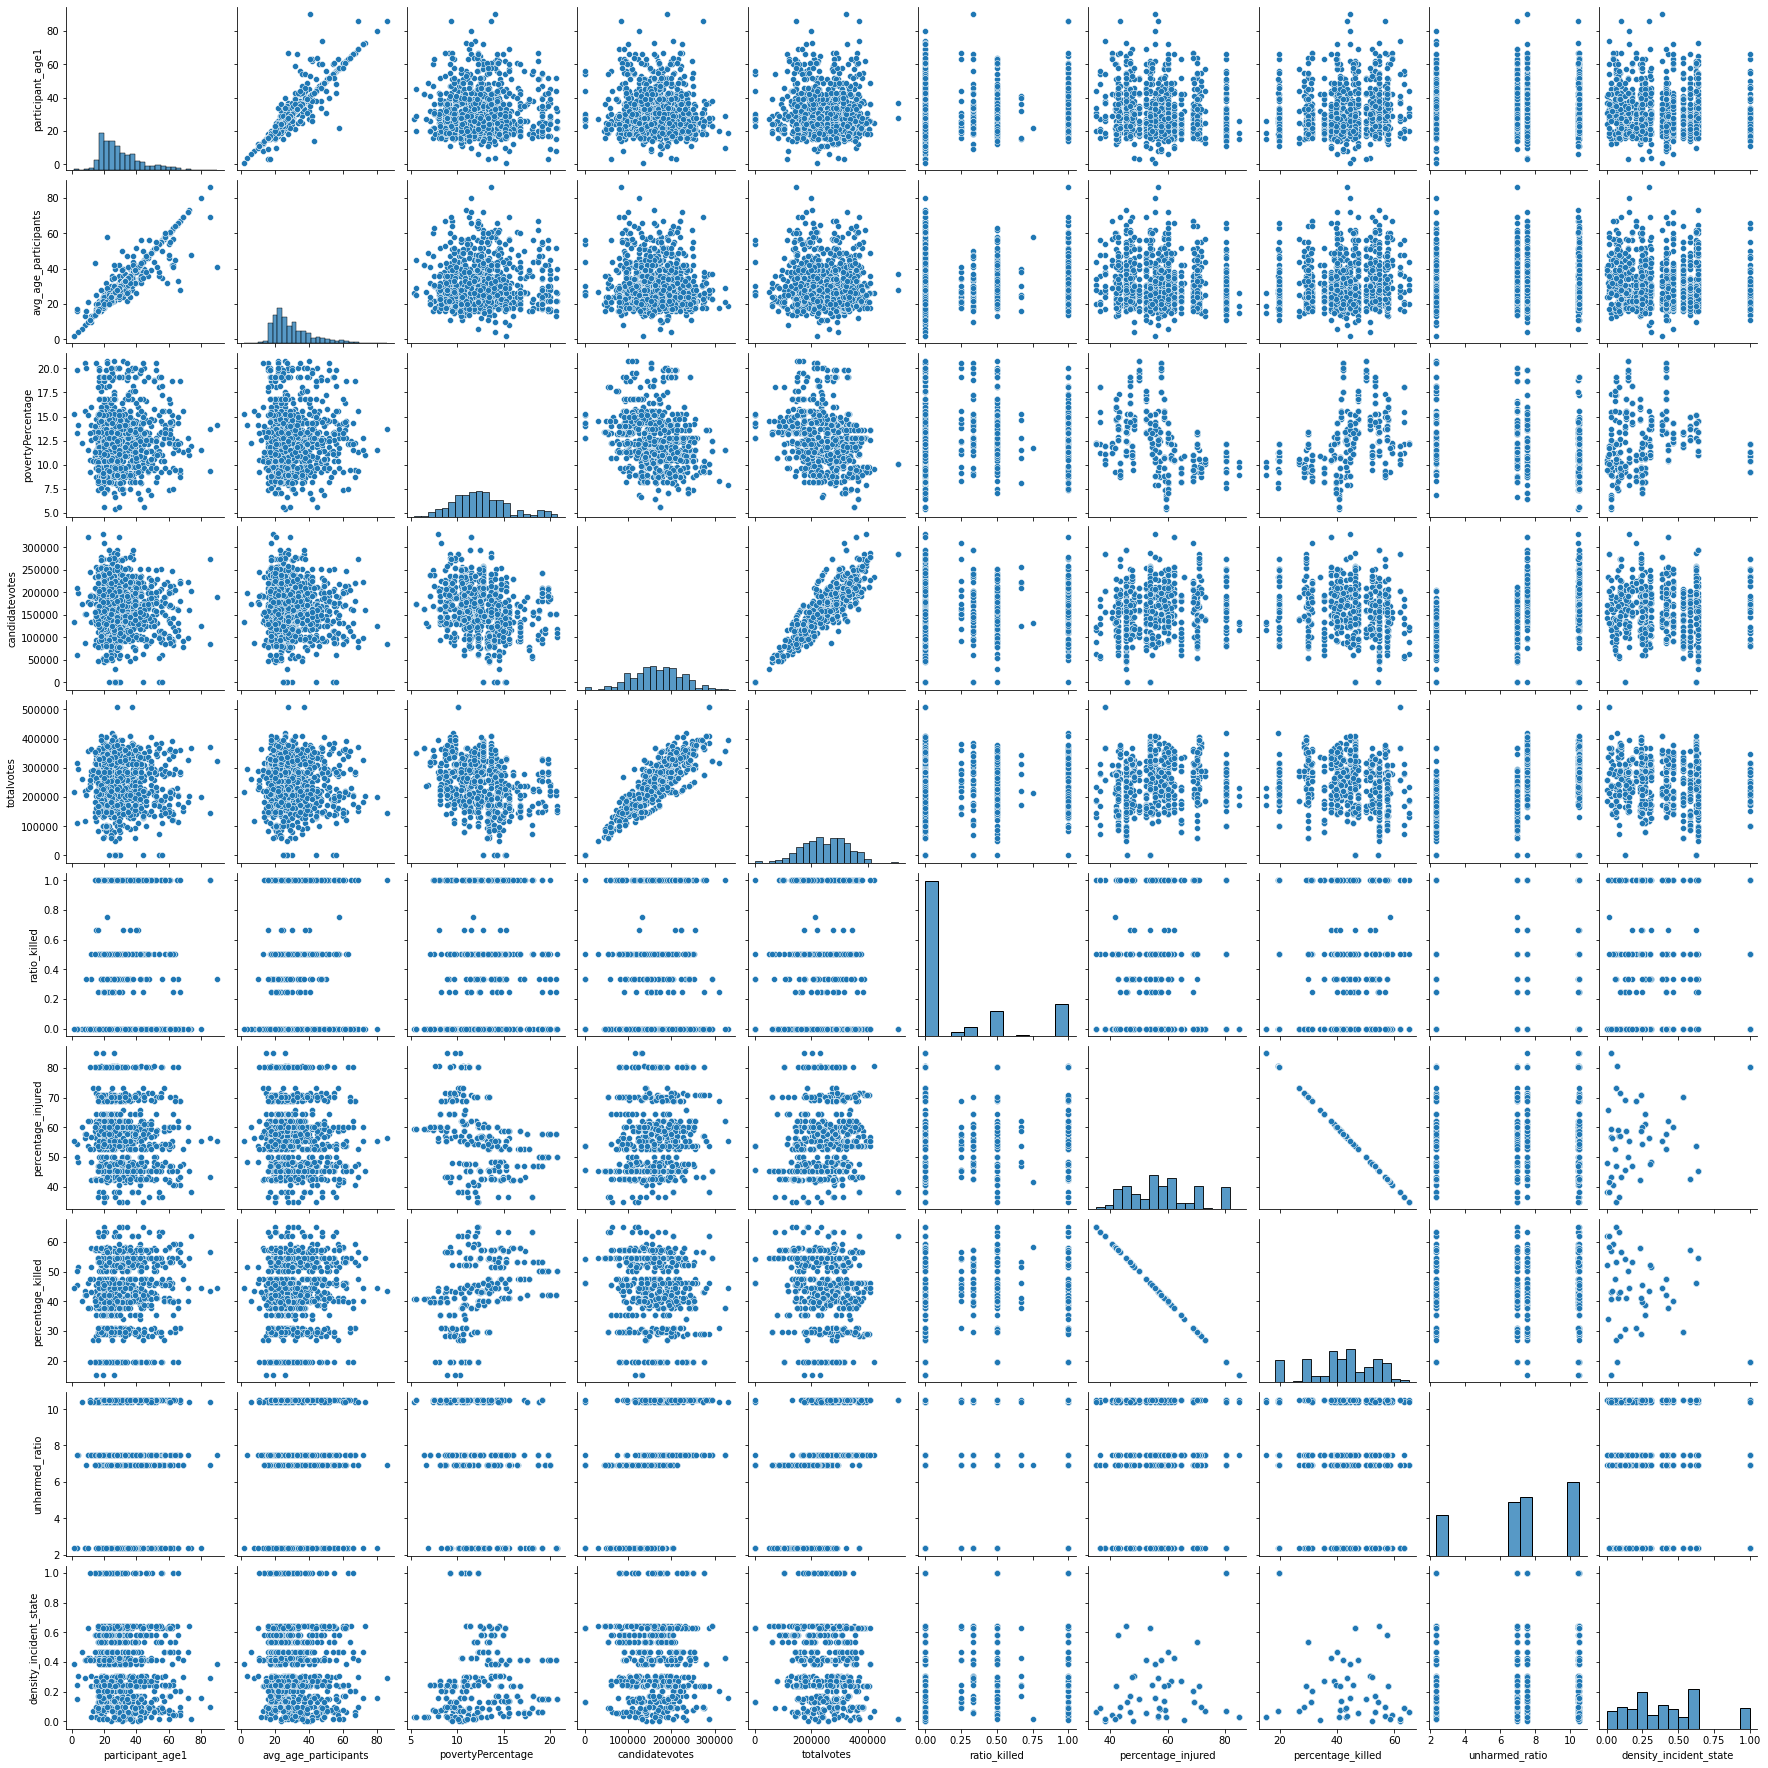

In [37]:
# We can see that intresting thing emerges when we exlude some of those columns so let's remove

# n_unharmed, year, n_participants, n_arrested, n_killed, n_females, n_participant_teen, n_participant_child

column_to_remove = ['n_injured','n_unharmed', 'year',
                    'n_participants', 'n_arrested', 'n_killed',
                    'n_females', 'n_participants_teen', 'n_participants_child',
                    'longitude', 'latitude', 'congressional_district', 'males_to_females_ratio']
# do pairplot without those columns
sns.pairplot(df_merged_sample.drop(column_to_remove, axis=1))

In [38]:
#check for nan
df_merged_pca.isnull().sum()

# fill the nans of candidate votes and total votes with 0
# make candidatevotes and totalvotes int
df_merged_pca['candidatevotes'].fillna(0, inplace=True)
df_merged_pca['totalvotes'].fillna(0, inplace=True)


df_merged_pca['candidatevotes'] = df_merged_pca['candidatevotes'].astype('int64')
df_merged_pca['totalvotes'] = df_merged_pca['totalvotes'].astype('int64')


# change the type of party by adding a new category 'None' for nan
df_merged_pca['party'] = df_merged_pca['party'].astype('category')
df_merged_pca['party'].cat.add_categories('None', inplace=True)


# save one for clustering
df_merged_clustering = df_merged_pca.copy()

# save the dataset in HDF5 format

df = df_merged_clustering
    
df.to_hdf('../ds/cleaned/clustering.h5', key='df', mode='w', format='table')

print('Data saved to ../ds/cleaned/clustering.h5')


/tmp/ipykernel_211893/3773656526.py:16: FutureWarning:

The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.



Data saved to ../ds/cleaned/clustering.h5


In [40]:
selected_features = df_merged_pca[['percentage_injured', 'unharmed_ratio',
                                                  'males_to_females_ratio', 
                                                  'totalvotes', 'povertyPercentage',
                                                  'density_incident_state', 'avg_age_participants']]


In [41]:
selected_features.head()

percentage_injured  unharmed_ratio  males_to_females_ratio  totalvotes  \
0           58.789954        2.345189                     2.0      206131   
1           45.310907        2.345189                     2.0      134043   
2           71.662763        2.345189                     0.0      273329   
3           70.237122        2.345189                     2.0      101606   
4           43.229167        2.345189                     1.0      281141   

   povertyPercentage  density_incident_state  avg_age_participants  
0               16.8                0.136149                    26  
1               14.5                0.639968                    28  
2               10.1                0.096973                    35  
3               13.4                0.534650                    29  
4               10.2                0.097775                    47

## Before PCA we need to preprocess

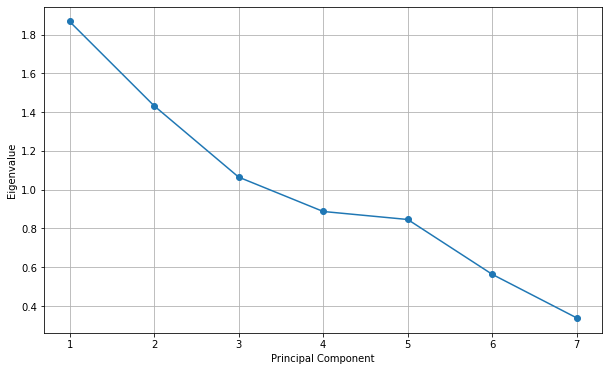

Index(['participant_age_group1', 'participant_gender1',
       'incident_characteristics1', 'party', 'death_level'],
      dtype='object')


" \n# project the two more separated components\nplt.figure(figsize=(10, 8))\nplt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_merged_pca['n_killed_per_participant'].cat.codes, cmap='viridis')\nplt.xlabel('First principal component')\nplt.ylabel('Second principal component')\nplt.title('Projection of incidents on the first two principal components')\nplt.show()\n\n "

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


scaler = StandardScaler()
#

#X_scaled = scaler.fit_transform(df_merged_pca.select_dtypes(include=[np.number]))
X_scaled = scaler.fit_transform(selected_features)

pca = PCA(n_components=7)
X_pca = pca.fit(X_scaled)

# getting eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

explained_variance_ratio = pca.explained_variance_ratio_

# Screeplot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o')
#add grid
plt.grid()
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()


# print categorical columns
print(df_merged_pca.select_dtypes(include=['category']).columns)


""" 
# project the two more separated components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_merged_pca['n_killed_per_participant'].cat.codes, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of incidents on the first two principal components')
plt.show()

 """

In [43]:
# take first 2 components
pca_2 = PCA(n_components = 2)

principal_components = pca_2.fit_transform(X_scaled)

# transform original dataframe with the new components
df_merged_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

MAX_SAMPLES = len(df_merged_pca)
# sample 4000 incidents
df_merged_pca = df_merged_pca.sample(n=40000, random_state=42)


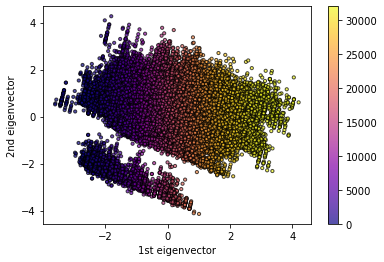

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set color palette for PC1, PC2, PC3
sns.set_palette('Set1', n_colors=3)

# Create scatter plot
scatter = plt.scatter(df_merged_pca['PC1'], df_merged_pca['PC2'], edgecolor='k', s=10, alpha=0.7, 
                      cmap=plt.get_cmap('plasma'), 
                      c=df_merged_pca['PC1'].astype('category').cat.codes)
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
# Add a color bar

plt.colorbar(scatter)

plt.show()

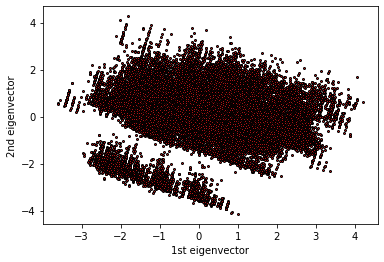

In [45]:
# take first 2 components
pca_3 = PCA(n_components = 3)

principal_components = pca_3.fit_transform(X_scaled)

# transform original dataframe with the new components
df_merged_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2', 'PC3'])

MAX_SAMPLES = len(df_merged_pca)
# sample 4000 incidents
df_merged_pca = df_merged_pca.sample(n=40000, random_state=42)

plt.scatter(df_merged_pca['PC1'], df_merged_pca['PC2'], cmap=plt.cm.Set1, edgecolor='k', s=4)
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
plt.show()

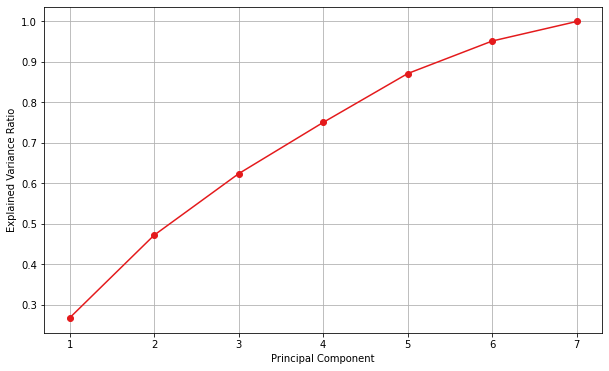

In [46]:
df_merged_pca.head()

# Plots comulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio)+1), np.cumsum(explained_variance_ratio), marker='o')
plt.grid()
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

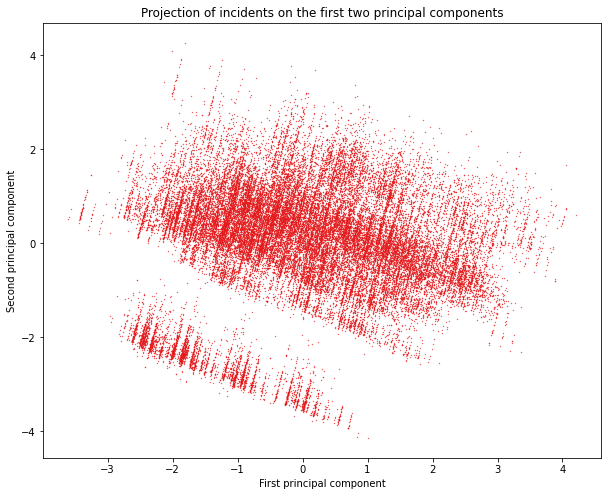

In [47]:
# Scatter plot of the first two components
plt.figure(figsize=(10, 8))
plt.scatter(df_merged_pca['PC1'], df_merged_pca['PC2'], s=0.1, cmap = 'viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of incidents on the first two principal components')
plt.show()

Text(0.5, 1.0, 'Projection of incidents on the second and third principal components')

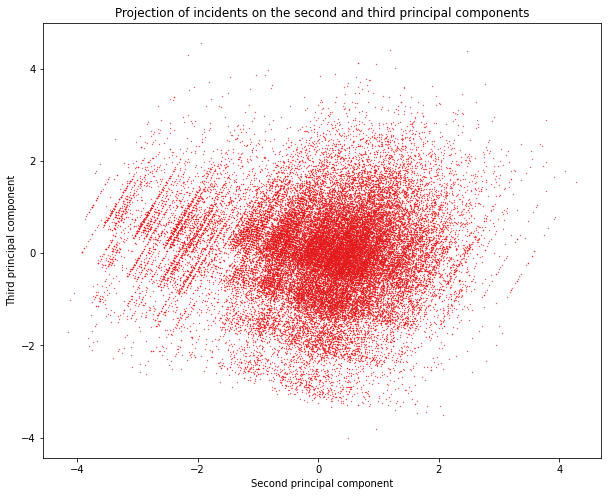

In [48]:
#Scatter plot of second and third components
plt.figure(figsize=(10, 8))
plt.scatter(df_merged_pca['PC2'], df_merged_pca['PC3'], s=0.1)
plt.xlabel('Second principal component')
plt.ylabel('Third principal component')
plt.title('Projection of incidents on the second and third principal components')

/tmp/ipykernel_211893/557366077.py:8: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



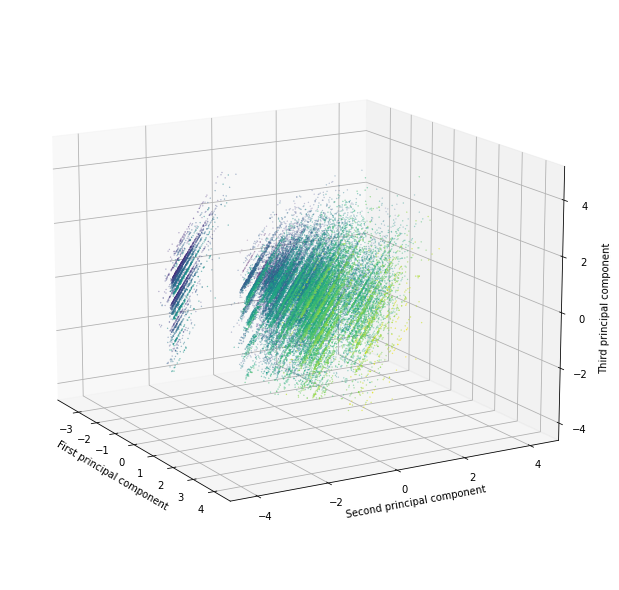

In [49]:
# Overlap three components
from mpl_toolkits.mplot3d import Axes3D
# color each component with different color


fig = plt.figure(figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 1, .90, 1], elev=15, azim=-30)
plt.cla()
ax.scatter(df_merged_pca['PC1'], df_merged_pca['PC2'], df_merged_pca['PC3'], c=df_merged_pca['PC1'], cmap='viridis', s=0.1)
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')
plt.show()


# Print what are the most important features for each component

# Clustering Analysis


## Geographical Clustering

1. We want to cluster the states based on the number of incidents per state. We will use the K-Means algorithm.
2. We can explore if some regions or states have similar incidents characteristics.

In [50]:
# Before Kmeans let's do some feature engineering

# We want to cluster state based on the number of incidents per state: we can use the density we computed before
# Now let's see the elbow method to see how many clusters we should use


In [51]:
# Import libraries for K-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm



# Select the features we want to use for clustering: States because we want incidents per state
# Let's encode the states with coordinate of our tuples of latitude and longitude

""" The way kmeans algorithm works is as follows:

    Specify number of clusters K.
    Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement.
    Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn’t changing.

    Compute the sum of the squared distance between data points and all centroids.
    Assign each data point to the closest cluster (centroid).
    Compute the centroids for the clusters by taking the average of the all data points that belong to each cluster.
"""

""" DENSITY_INCIDENT_STATE = False

if DENSITY_INCIDENT_STATE:
    ## KMenas clustering for incident x state using the density of incidents per state
    X = df_merged[['density_incident_state']].values
else:
    # Assuming df is your DataFrame with latitude and longitude columns
    X = df[['latitude', 'longitude']]
"""

#X = df_merged[['povertyPercentage']].values
 
#X = df_merged_clustering[['candidatevotes', 'totalvotes']].values 

X = df_merged_pca[['PC1', 'PC2', 'PC3']].values

# Standardize the features (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# We want to cluster the states based on the number of incidents per state
# We want to find the optimal number of clusters using the elbow method
# We want to use the silhouette score to evaluate the quality of the clusters

# We will try different number of clusters from 2 to 10
n_clusters = np.arange(2, 11)

silhouette_scores = []
inertia_scores = []
kmeans_models = []
elbow_scores = []

# For each number of clusters
for n in tqdm(n_clusters):
    # Initialize the KMeans model with n_clusters=n
    # Use KMenans++ initialization for faster convergence
    kmeans = KMeans(n_clusters=n, random_state=42,
                    n_init=1, max_iter=1, algorithm='lloyd', init='k-means++')

    # Fit the model
    kmeans.fit(X)
    print("Current model:", kmeans)
    
    # Get the inertia score
    inertia_scores.append(kmeans.inertia_)
    print("Current inertia score:", kmeans.inertia_)
    
    # Get the silhouette score
    #silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    #print("Current silhouette score:", silhouette_score(X, kmeans.labels_))
    
    # Store the model
    kmeans_models.append(kmeans)

 22%|██▏       | 2/9 [00:00<00:00,  7.40it/s]

Current model: KMeans(max_iter=1, n_clusters=2, n_init=1, random_state=42)
Current inertia score: 143671.97727860924
Current model: KMeans(max_iter=1, n_clusters=3, n_init=1, random_state=42)
Current inertia score: 103886.31360873162


 44%|████▍     | 4/9 [00:00<00:00,  7.71it/s]

Current model: KMeans(max_iter=1, n_clusters=4, n_init=1, random_state=42)
Current inertia score: 93281.9724313453
Current model: KMeans(max_iter=1, n_clusters=5, n_init=1, random_state=42)
Current inertia score: 85601.26801383508


 67%|██████▋   | 6/9 [00:00<00:00,  7.13it/s]

Current model: KMeans(max_iter=1, n_clusters=6, n_init=1, random_state=42)
Current inertia score: 61070.2874940411
Current model: KMeans(max_iter=1, n_clusters=7, n_init=1, random_state=42)
Current inertia score: 59334.91209847714


 89%|████████▉ | 8/9 [00:01<00:00,  7.39it/s]

Current model: KMeans(max_iter=1, n_init=1, random_state=42)
Current inertia score: 55554.01222481977
Current model: KMeans(max_iter=1, n_clusters=9, n_init=1, random_state=42)
Current inertia score: 51177.069957711545


100%|██████████| 9/9 [00:01<00:00,  7.31it/s]

Current model: KMeans(max_iter=1, n_clusters=10, n_init=1, random_state=42)
Current inertia score: 48761.874305613135


# Eblow method to get ideal number of clusters

We can see that the ideal number of clusters is 5.

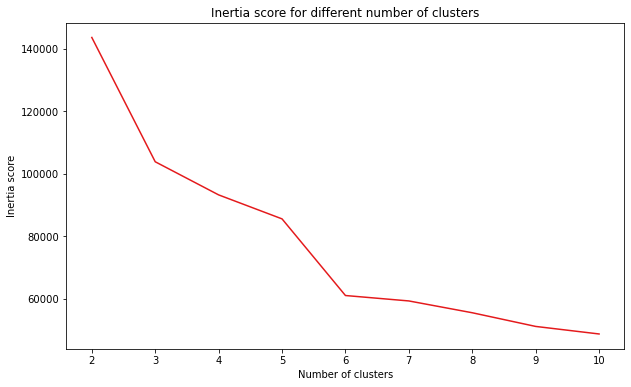

In [52]:
# Plot the inertia score for each number of clusters o
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, inertia_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia score')
plt.title('Inertia score for different number of clusters')
plt.show()




In [58]:

N_CLUSTER_PREDICT = 6

df_clusters = df_merged.copy()

df_merged_pca['cluster'] = kmeans_models[N_CLUSTER_PREDICT-2].labels_

# Add the cluster labels to the dataframe
# We do -2 because we start from 2 clusters
#df_clusters['cluster'] = kmeans_models[N_CLUSTER_PREDICT-2].labels_

# centroids
centroids = kmeans_models[N_CLUSTER_PREDICT-2].cluster_centers_


# For logitude and latitude clustering visualization

# Poverty Percentage clustering

#todo

# Votes clustering

As expected we have three clusters, one for each party.

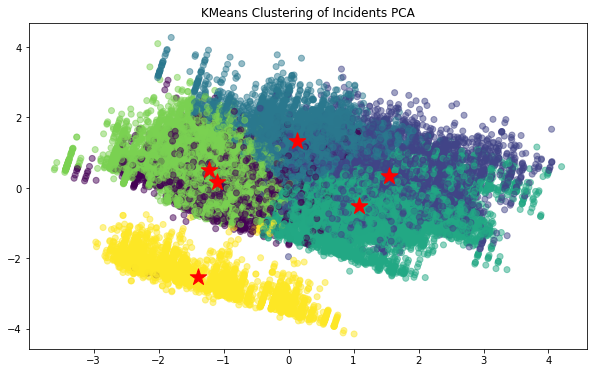

In [59]:
# Visualize the clusters (scatter plot of latitude and longitude with different colors for each cluster)
plt.figure(figsize=(10, 6))

#plt.scatter(df_clusters['longitude'], df_clusters['latitude'], c=df_clusters['cluster'], cmap='viridis', alpha=0.5)
plt.scatter(df_merged_pca['PC1'], df_merged_pca['PC2'], c=df_merged_pca['cluster'], cmap='viridis', alpha=0.5)

plt.title('KMeans Clustering of Incidents PCA')
# add centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300, c='r')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
plt.show()



## More clustering ideas:

- Clustering on the entire dataset
- Density based: DBSCAN
- Characterization of the obtained clusters by using both analysis of
the k centroids and comparison of the distribution of variables within
the clusters and that in the whole dataset